In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='448216e6-8edf-4667-a9bd-c70acd8b95c7', project_access_token='p-626c5b7bb5bbbb567b30200f0040fd73149ebff6')
pc = project.project_context


# Mortgage Approval Prediction

### Contents
- [Set up Project Token and API Key](#tokens)
- [Import Libraries](#libraries)
- [Setup AI Factsheets](#factsheet)
- [Load training data](#data)
- [Specify User Inputs](#userinputs)
- [Build Data Pipelines](#transformers)
- [Build Machine Learning Models](#ml)
- [View Model Results](#results)
- [Save the model](#save)

### Set up Project Token and API Key  <a name="tokens"></a>
Before executing this notebook, you need to insert a project token and an IBM Cloud API key:<br>

#### Provide the project access token
1. When you imported the project from the Gallery, the first cell of this notebook should contain the project access token. 

2. If this notebook does not contain a first cell with a project access token, then to generate the token, click **More > Insert project token** on the menu bar.<br>

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)


#### Provide your IBM Cloud API key
1. Generate an IBM Cloud API key on the [API Keys page in the IBM Cloud console](https://cloud.ibm.com/iam/apikeys).
2. Click **Create an IBM Cloud API key**. Provide a key name, and click **Create**, then copy the created key and paste it below. As a best practice, download the API key in addition to copying the key. 


In [2]:
ibmcloud_api_key = '2BDXSVijZILATG_DiUWIpxrAnooB7b6ejiysXxs5orzv'

You can then step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell > Run All** from the menu.<br>

### Import Libraries  <a name="libraries"></a>

This cell imports the python libraries that you will use throughout the notebook. 
`matplotlib` and `seaborn` libraries are used to visualize the data. The code uses the `sklearn` library to build transformers and machine learning models. 

In [3]:

import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os

import seaborn as sns
sns.set(style='darkgrid',palette="deep")

import ibm_db, ibm_db_dbi as dbi


from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn import metrics

!pip install ibm-cloud-sdk-core

### Set up AI Factsheets  <a name="factsheet"></a>

[AI Factsheets](https://aifs360.mybluemix.net/introduction) will be used to track the lifecycle of the model built using sci-kit library. This cell imports the AI Factsheets client and creates an experiment to log the results to AI Factsheets.

In [4]:

try:
    from ibm_aigov_facts_client import AIGovFactsClient
except:
    !pip install -U ibm-aigov-facts-client
    from ibm_aigov_facts_client import AIGovFactsClient
        
        
PROJECT_UID= os.environ['PROJECT_ID'] #this assumes you are running in Studio. When running externally please add the project id here.
CPD_URL=os.environ['RUNTIME_ENV_APSX_URL'][len('https://api.'):] #the variable starts with https://api." and you only need the rest 'dataplatform.dev.cloud.ibm.com'
CONTAINER_ID=PROJECT_UID
CONTAINER_TYPE='project'
EXPERIMENT_NAME='mortgage_approval_prediction'
# CPD4D API key. Navigate to hamburger menu -> Acess (IAM) -> API Keys to create one for you (or have your account admin do it)

# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
PROJECT_ACCESS_TOKEN=project.project_context.accessToken.replace('Bearer ','') #You can create or lookup such a token from the settings tab of this project



facts_client = AIGovFactsClient(api_key=ibmcloud_api_key,experiment_name=EXPERIMENT_NAME,container_type=CONTAINER_TYPE,container_id=CONTAINER_ID,set_as_current_experiment=True)

     |████████████████████████████████| 106 kB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 547 kB 34.9 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 3.0 MB/s  eta 0:00:01
     |████████████████████████████████| 3.5 MB 59.5 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 14.3 MB/s eta 0:00:01
     |████████████████████████████████| 182 kB 66.9 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 3.0 MB/s  eta 0:00:01
  Created wheel for databricks-cli: filename=databricks_cli-0.17.3-py3-none-any.whl size=139103 sha256=6c4da6a066e65539566edcf92d2555b40816d51a3a430ade61727a81df872fd0
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/7b/ef/c5/85718fa9e66dec117e42d8b4d7b8a2e40ebdec17232935615f
  Created wheel for timeout-decorator: filename=timeout_decorator-0.5.0-py3-none-any.whl size=5028 sha256=33eaf0ab28cda6d2d354e953038b41ddec6e2ffeede18a98e5960edfa2772482
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/5d/45/1d/a7d2bf

### Connect to a Database 

In [5]:
DATABASE_CREDENTIALS=project.get_connection(name="Data Fabric Trial - Db2 Warehouse")

In [6]:
db2_warehouse_datafabric_trial_dsn = 'DATABASE={};HOSTNAME={};PORT={};PROTOCOL=TCPIP;UID={uid};PWD={pwd};SECURITY=SSL'.format(DATABASE_CREDENTIALS['database'],DATABASE_CREDENTIALS['host'],DATABASE_CREDENTIALS['port'],uid=DATABASE_CREDENTIALS['username'],pwd=DATABASE_CREDENTIALS['password'])

db2_warehouse_datafabric_trial_connection = dbi.connect(db2_warehouse_datafabric_trial_dsn)
   

#### SQL Query to read the tables
The SQL Query below returns the raw data required to train the model.

In [7]:
sql_query='select * from AI_MORTGAGE.MORTGAGE_APPROVAL_VIEW'

### Load  training data   <a name="data"></a>

Load the received data into a Pandas dataframe.

In [8]:
df_mortgage = pd.read_sql_query(sql_query, con=db2_warehouse_datafabric_trial_connection)

df_mortgage.head()

,ID,NAME,STREET_ADDRESS,CITY,STATE,STATE_CODE,ZIP_CODE,EMAIL_ADDRESS,PHONE_NUMBER,GENDER,SOCIAL_SECURITY_NUMBER,EDUCATION,EMPLOYMENT_STATUS,MARITAL_STATUS,INCOME,APPLIEDONLINE,RESIDENCE,YRS_AT_CURRENT_ADDRESS,YRS_WITH_CURRENT_EMPLOYER,NUMBER_OF_CARDS,CREDITCARD_DEBT,LOANS,LOAN_AMOUNT,CREDIT_SCORE,COMMERCIAL_CLIENT,COMM_FRAUD_INV,PROPERTY_VALUE,AREA_AVG_PRICE,MORTGAGE_APPROVAL
0,110424,Adah Marks,4355-5 Pelham South,Park Ridge,Illinois,IL,41227,Adah.Marks@donny.ca,206-220-3128,Male,403-49-3266,College,Employed,Married,49051.0,YES,Owner Occupier,11,12,2,1168.0,1,7478.0,547,FALSE,FALSE,548618.0,NaN,0
1,110425,Jerrell Eichmann,5642-1 Hwy 78 East,Reston,Virginia,VA,41198,Jerrell.Eichmann@trycia.biz,972-510-7295,Male,394-17-0450,High School or Below,Unemployed,Married,49052.0,YES,Owner Occupier,11,12,2,1167.0,1,7476.0,547,TRUE,FALSE,548638.0,NaN,0
2,110426,Glennie Barrows,6736-1 Whitfield Ave,Houston,Texas,TX,41169,Glennie.Barrows@elwin.us,609-564-9894,Female,295-29-1540,High School or Below,Employed,Married,49053.0,YES,Owner Occupier,11,12,2,1166.0,1,7474.0,547,FALSE,FALSE,548658.0,NaN,0
3,110427,Susanna Schaefer,4529-0 Madison Blvd,Woodridge,Illinois,IL,41140,Susanna.Schaefer@elta.ca,484-261-6798,Female,204-81-0296,Bachelor,Employed,Married,49054.0,YES,Public Housing,11,12,2,1165.0,1,7471.0,547,FALSE,FALSE,548678.0,NaN,0
4,110428,Jettie Waters,3698-Kelley Blvd,Truckee,California,CA,41110,Jettie.Waters@kacie.co.uk,253-973-4793,Male,161-55-7466,College,Unemployed,Single,49054.0,YES,Living with parents/guardian,11,12,2,1164.0,1,7469.0,546,TRUE,FALSE,548698.0,721244.0,0


### Specify User Inputs <a name="userinputs"></a>

These user inputs are defined in the cell below.

**target_col :** This is the target column indicating whether a mortgage application is approved or not.<br>
**categorical_cols :** A list of all categorical variables that need to be transformed before input into the model. You will use a transformer to impute missing values and create dummy variables.<br>
**numerical_cols :** A list of all of the numerical features that you input into the model. Later in the code, you use a transformer to impute any missing values in these columns. Flag like variables, with values of either 1 or 0 are included in this list.<br>
**cat_pct :** A threshold that defines the percentage of unique values in a categorical feature that is acceptable for one-hot encoding.<br>
**cor_pct :** A threshold that defines the level of correlation, at which point a feature needs to be removed from analysis.<br>


If the data scientist is using their own data, they can easily update the variables below to point at their own specific column names.

All of these variables are stored in a dictionary which is saved as part of the metadata when deploying the pipeline in the deployment space. you store this dictionary so that the same user inputs can be applied when scoring new data.

In [11]:
numerical_cols=['INCOME','YRS_AT_CURRENT_ADDRESS','YRS_WITH_CURRENT_EMPLOYER','NUMBER_OF_CARDS','CREDITCARD_DEBT','LOAN_AMOUNT','CREDIT_SCORE','PROPERTY_VALUE','AREA_AVG_PRICE','LOANS']
target_col='MORTGAGE_APPROVAL'
categorical_cols=['STATE','GENDER','EDUCATION','EMPLOYMENT_STATUS','MARITAL_STATUS','APPLIEDONLINE','RESIDENCE','COMMERCIAL_CLIENT','COMM_FRAUD_INV']


cat_pct = 0.04
cor_pct = 0.90

In [12]:
df_prep=df_mortgage[numerical_cols+[target_col]+categorical_cols].copy()

In [13]:
df_prep.head()

,INCOME,YRS_AT_CURRENT_ADDRESS,YRS_WITH_CURRENT_EMPLOYER,NUMBER_OF_CARDS,CREDITCARD_DEBT,LOAN_AMOUNT,CREDIT_SCORE,PROPERTY_VALUE,AREA_AVG_PRICE,LOANS,MORTGAGE_APPROVAL,STATE,GENDER,EDUCATION,EMPLOYMENT_STATUS,MARITAL_STATUS,APPLIEDONLINE,RESIDENCE,COMMERCIAL_CLIENT,COMM_FRAUD_INV
0,49051.0,11,12,2,1168.0,7478.0,547,548618.0,NaN,1,0,Illinois,Male,College,Employed,Married,YES,Owner Occupier,FALSE,FALSE
1,49052.0,11,12,2,1167.0,7476.0,547,548638.0,NaN,1,0,Virginia,Male,High School or Below,Unemployed,Married,YES,Owner Occupier,TRUE,FALSE
2,49053.0,11,12,2,1166.0,7474.0,547,548658.0,NaN,1,0,Texas,Female,High School or Below,Employed,Married,YES,Owner Occupier,FALSE,FALSE
3,49054.0,11,12,2,1165.0,7471.0,547,548678.0,NaN,1,0,Illinois,Female,Bachelor,Employed,Married,YES,Public Housing,FALSE,FALSE
4,49054.0,11,12,2,1164.0,7469.0,546,548698.0,721244.0,1,0,California,Male,College,Unemployed,Single,YES,Living with parents/guardian,TRUE,FALSE


#### Handle categorical variables
Categorical variables with a high number of unique values can significantly impact performance, because they may add too many one-hot encoded features to the dataset. Such categorical variables need to be removed.

In [15]:
for col in categorical_cols:
    if df_prep[col].nunique() > (cat_pct*df_prep.shape[0]):
        print(col,"removed")
        categorical_cols.remove(col)
        df_prep=df_prep.drop(col,axis=1)

STATE removed


Also remove the columns which have only one single category for all the rows.

In [16]:
for col in categorical_cols:
    if df_prep[col].nunique() ==1:
        print(col,"removed")
        categorical_cols.remove(col)
        df_prep=df_prep.drop(col,axis=1)

Training Data

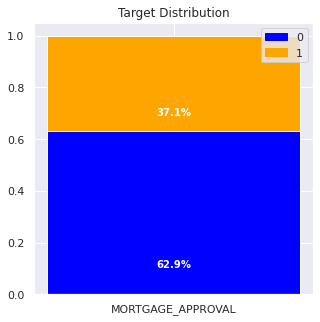

In [17]:

df_temp = df_prep[target_col].value_counts().reset_index()
df_temp['perc'] = df_temp[target_col] / df_temp[target_col].sum()

target_0 = df_temp[df_temp['index']==0]['perc'].values[0]
target_1 = df_temp[df_temp['index']==1]['perc'].values[0]

fig1, ax1 = plt.subplots(figsize=(5,5))

ax1.bar(target_col, target_0, label=target_0, color='blue')
ax1.bar(target_col, target_1, bottom=target_0, color='orange')

red_patch = mpatches.Patch(color='orange', label='1')
blue_patch = mpatches.Patch(color='blue', label='0')

plt.legend(handles=[blue_patch, red_patch], loc='best')

plt.title('Target Distribution')

for patch in ax1.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height())
    x = patch.get_x() + patch.get_width()/2
    y = patch.get_y() + patch.get_height()/6
    ax1.annotate(percentage, (x, y), ha='center', color='white', weight='bold', fontsize=10)

#### Correlation
You will carry out a correlation analysis on all variables specified in numerical_cols.

From the result of the analysis, you can see that there is no significant correlation between the columns. 

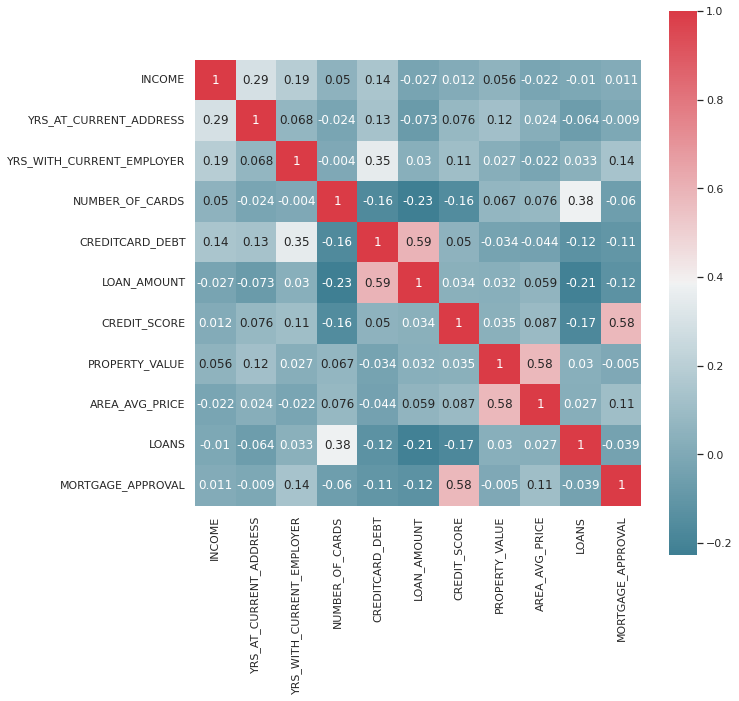

In [18]:
# check correlation between numerical features
f, ax = plt.subplots(figsize=(10, 10))
corr = df_prep[numerical_cols + [target_col]].corr()
corr = corr.round(3)
temp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax,annot=True)

#### Handle correlations
Correlated data poses the threat of disproportionately reporting the effects of features with relatively similarly. This cell removes highly correlated columns, if any.

In [20]:
corr = corr.abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] >= cor_pct)]

df_prep = df_prep.drop(to_drop, axis=1)

if(len(to_drop)>0):
    numerical_cols.remove(to_drop[0])
    print(to_drop,"Removed because of high correlation")

### Build Data Pipelines  <a name="transformers"></a>
#### Split Data and Build Transformer


The data needs to be split into training, validation and test sets. You will be using 80% of the data for training, and the remaining 20% for testing. At this point, you will also be removing records with missing values for the target variable. 

You build the models on the training set, carry out hyperparameter tuning on the test set and finally apply the selected final model. Sci-kit learn's transformers will be leveraged to process and prepare the data.


In [21]:
X = df_prep.dropna(axis=0, subset=[target_col]).drop([target_col], axis=1)
y = df_prep.dropna(axis=0, subset=[target_col])[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)


For categorical variables,a 2 step pipeline is created. The `SimpleImputer` transformer will fill in missing values with 'Other', while the `OneHotEncoder` transformer will create dummy variables for each category. The transformers are applied to the features specified in the `categorical_cols` variable.

For `numerical_cols`variables the pipeline has a single step in our example. You again leverage the `SimpleImputer` transformer to fill in missing values.



In [22]:
categorical_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='constant', fill_value='Other')), ('dummy_vars', OneHotEncoder(handle_unknown='ignore'))])
# fill in missing data - you use median to keep the 1, 0  'flag' like variables either 1 or 0
numeric_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='median'))])

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
            ])

Once the transformers are combined, you perform a fit using the training data and transform the training, validation and test data. The transformer is saved out as a joblib object. It can be imported and used again when preparing new data for scoring. The feature names of the combined transformers are retrieved and stored in a list `numerical_cols`. This list is used for labelling the feature importance of the final model.

In [24]:
fitted_preprocessor = preprocessor.fit(X_train)

X_train_postprocess = fitted_preprocessor.transform(X_train)

X_test_postprocess = preprocessor.transform(X_test)

In [25]:
onehot_columns=list(fitted_preprocessor.named_transformers_['cat'].named_steps['dummy_vars'].get_feature_names_out(input_features=categorical_cols))
numeric_features_list = list(numerical_cols)
numeric_features_list.extend(onehot_columns)

### Building Machine Learning Models <a name="ml"></a>

#### Model Hyperparameter Tuning and Model Selection

A Random Forest Model will be used for this tutorial, and that will require some hyperparameter tuning. The hyperparameter selection which performs best on the imbalanced validation data is selected as final. To determine this, you will be using ROC AUC as the evaluation metric.

In [26]:
l_ne = [10, 50]
l_md = [5,7, 10] 
l_mf = [0.75, 0.9]

highest_test_auc = 0.0
top_ne = 0
top_md = 0
top_mf = 0.0

for ne in l_ne:
    for md in l_md:
        for mf in l_mf:
            clf = RandomForestClassifier(n_estimators=ne, max_depth=md, max_features=mf, random_state=0)
            clf.fit(X_train_postprocess, y_train)
            
            y_pred_train = clf.predict_proba(X_train_postprocess)[:,1]
            y_pred_test = clf.predict_proba(X_test_postprocess)[:,1]
            
            fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)
            fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)

            auc_test = metrics.auc(fpr_test, tpr_test)
            auc_train = metrics.auc(fpr_train, tpr_train)
            
            if auc_test > highest_test_auc:
                print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Test AUC :' + str(np.round(auc_test, 3)) + ' from ' + str(ne) + ' estimators, ' + str(md) + ' max depth and ' + str(mf) + ' max features***')
                top_ne = ne
                top_md = md
                top_mf = mf
                highest_test_auc = auc_test
            else:
                print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Test AUC :' + str(np.round(auc_test, 3)) + ' from ' + str(ne) + ' estimators, ' + str(md) + ' max depth and ' + str(mf) + ' max features')
                

2022/12/02 01:04:31 INFO : logging results to factsheet for run_id 2bb0b60cc3fa4eb7bcf075692b1f76f1
2022/12/02 01:04:32 INFO : Successfully logged results to Factsheet service for run_id 2bb0b60cc3fa4eb7bcf075692b1f76f1 under asset_id: 5dffc21c-6a66-4917-93cd-ef32204a8e45 and project_id : 448216e6-8edf-4667-a9bd-c70acd8b95c7
Training AUC : 0.998, Test AUC :0.967 from 10 estimators, 5 max depth and 0.75 max features***
2022/12/02 01:04:33 INFO : logging results to factsheet for run_id 57160e905f8d447ca2a75fbaa7fca786
2022/12/02 01:04:34 INFO : Successfully logged results to Factsheet service for run_id 57160e905f8d447ca2a75fbaa7fca786 under asset_id: 5dffc21c-6a66-4917-93cd-ef32204a8e45 and project_id : 448216e6-8edf-4667-a9bd-c70acd8b95c7
Training AUC : 0.997, Test AUC :0.969 from 10 estimators, 5 max depth and 0.9 max features***
2022/12/02 01:04:34 INFO : logging results to factsheet for run_id b264bff0b1d74e238197585a3c9e71e1
2022/12/02 01:04:35 INFO : Successfully logged results to

### Build Final Model 

After finding the best performing hyperparameter combination, you apply them to our final model. The model is built using training data and then evaluated using validation data. The final model and results are logged into the factsheet experiment.

In [27]:
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', RandomForestClassifier(n_estimators=top_ne, max_depth=top_md, max_features=top_mf, random_state=0))])

clf=model_pipeline.fit(X_train, y_train)
y_pred_train=model_pipeline.predict(X_train)
y_pred_test=model_pipeline.predict(X_test)

y_pred_train = model_pipeline.predict_proba(X_train)[:,1]
#y_pred_validation = model_pipeline.predict_proba(X_validation)[:,1]
y_pred_test = model_pipeline.predict_proba(X_test)[:,1]



fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)
#fpr_validation, tpr_validation, thresholds_validation = metrics.roc_curve(y_validation, y_pred_validation)
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)

auc_train = metrics.auc(fpr_train, tpr_train)
#auc_validation = metrics.auc(fpr_validation, tpr_validation)
auc_test = metrics.auc(fpr_test, tpr_test)

print('Training AUC : ' + str(np.round(auc_train, 3)) +  ' and Test AUC :' + str(np.round(auc_test, 3)) + ' from ' + str(top_ne) + ' estimators, ' + str(top_md) + ' max depth and ' + str(top_mf) + ' max features')



2022/12/02 01:04:52 INFO : logging results to factsheet for run_id 823768d67b8143f5ac417398d6f52a70
2022/12/02 01:04:53 INFO : Successfully logged results to Factsheet service for run_id 823768d67b8143f5ac417398d6f52a70 under asset_id: 5dffc21c-6a66-4917-93cd-ef32204a8e45 and project_id : 448216e6-8edf-4667-a9bd-c70acd8b95c7
Training AUC : 1.0 and Test AUC :0.978 from 50 estimators, 7 max depth and 0.9 max features


### View Model Results <a name="results"></a>

First you'll look at the plot of the ROC curve since you used area under the ROC curve (AUC) as the model evaluation metric. The ROC curve is a plot of the true positive rate `(Sensitivity)` and false positive rate `(Specificity)`. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold.

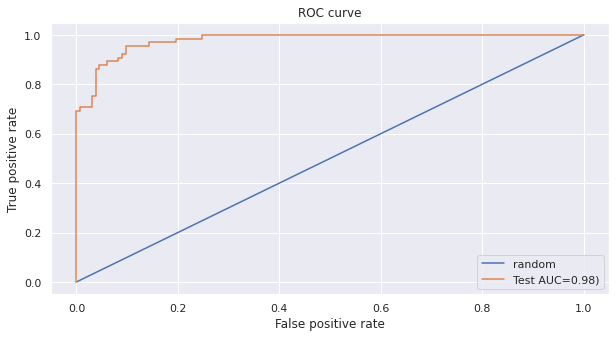

In [28]:
fig = plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], label='random')

#plt.plot(fpr_validation, tpr_validation, label= 'Validation AUC=' + str(np.round(auc_test, 2)) + ')')
plt.plot(fpr_test, tpr_test, label= 'Test AUC=' + str(np.round(auc_test, 2)) + ')')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

In [29]:
# get the optimal threshold based on Youden's index
idx_opt_thres = np.argmax(tpr_test - fpr_test)
opt_threshold = thresholds_test[idx_opt_thres]
print(opt_threshold)
y_pred_class_test = y_pred_test >= opt_threshold
y_pred_class_test = y_pred_class_test.astype(int)
#y_pred_class_test = y_pred_test >= opt_threshold
#y_pred_class_test = y_pred_test.astype(int)

0.33494044955995816


You'll next look at the confusion matrices for the validation and test results at the threshold selected above. At this threshold the classifier does a good job at correctly predicting those who readmit or not. However, it also misclassifies quite a few customers as who are approved of loan as not approved (False Positives). This result may not be sufficient to the Bank. Based on this, the analyst may want to change the threshold by reducing the false positive rate (as commented out above). Doing this does result in a trade off and the number of true positives (individuals that will truly default on their loans) would reduce. 

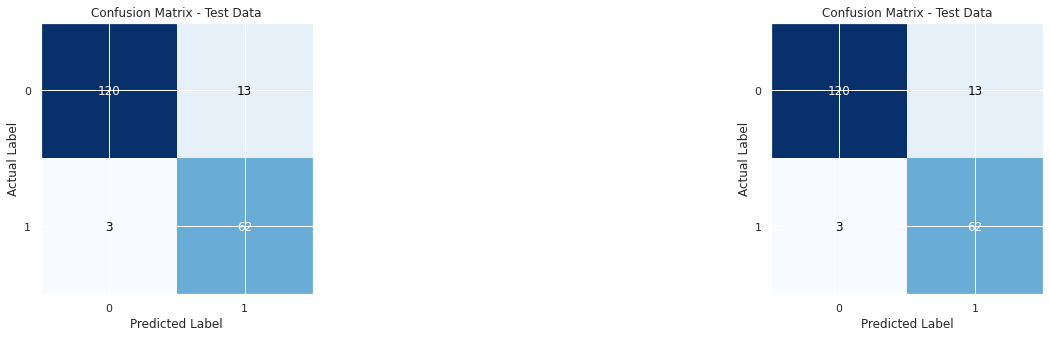

In [30]:
confusion_matrix_validation = metrics.confusion_matrix(y_test, y_pred_class_test, labels=[0,1])
confusion_matrix_test = metrics.confusion_matrix(y_test, y_pred_class_test, labels=[0,1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 5))

ax1.imshow(confusion_matrix_validation, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('Confusion Matrix - Test Data')
tick_marks = np.arange(2)
ax1.set_xticks(tick_marks)
ax1.set_yticks(tick_marks)
ax1.set_ylabel('Actual Label')
ax1.set_xlabel('Predicted Label')
# iterate through the confusion matrix array with indexing, use this to plot counts on the chart
cm_iterator = np.nditer(confusion_matrix_validation, flags=['multi_index'])
while not cm_iterator.finished:
    num_occurances = cm_iterator[0]
    y = cm_iterator.multi_index[0]
    x = cm_iterator.multi_index[1]
    ax1.text(x, y, num_occurances, color="white" if confusion_matrix_validation[x, y] > confusion_matrix_validation.max()/2 else "black", ha='center', va='center')
    cm_iterator.iternext()

ax2.imshow(confusion_matrix_test, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title('Confusion Matrix - Test Data')
ax2.set_xticks(tick_marks)
ax2.set_yticks(tick_marks)
ax2.set_ylabel('Actual Label')
ax2.set_xlabel('Predicted Label')
# iterate through the confusion matrix array with indexing, use this to plot counts on the chart
cm_iterator = np.nditer(confusion_matrix_test, flags=['multi_index'])
while not cm_iterator.finished:
    num_occurances = cm_iterator[0]
    y = cm_iterator.multi_index[0]
    x = cm_iterator.multi_index[1]
    ax2.text(x, y, num_occurances, color="white" if confusion_matrix_test[x, y] > confusion_matrix_test.max()/2 else "black", ha='center', va='center')
    cm_iterator.iternext()

### Save the Model <a name="save"></a>

You select the top performing model pipeline. In the next steps, you save the model pipeline along with metadata information in the project using [ibm-watson-machine-learning](http://ibm-wml-api-pyclient.mybluemix.net) client.




#### User Inputs

The user can specify the name for the model below.  <br>


In [31]:

model_name = 'Mortgage Approval Prediction Model'


This cell imports `ibm_watson_machine_learning` library and then creates a wml client using the credentials provided.

In [32]:
from ibm_watson_machine_learning import APIClient

location = os.environ['RUNTIME_ENV_REGION'] 
wml_credentials = {
    "apikey": ibmcloud_api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}
client = APIClient(wml_credentials)

Set the current project as the default project to save the model.

In [33]:
client.set.default_project(PROJECT_UID)

'SUCCESS'

#### Storing Pipeline Details

Storing the model requires us to curate and specify some properties:</br>
• The name for the pipeline as specified above </br>
• Training data reference, that points to the data used to train the model.</br>
• The Software Specification, that refers to the runtime used in this Notebook and the WML deployment. You use the software specification `default_py3.8` to store the models.</br>

In [34]:
fields=X_train.columns.tolist()
metadata_dict = {'target_col' : target_col, 'probability_threshold' : opt_threshold, 'numeric_features_list':numeric_features_list,'fields':fields,'categorical_cols':categorical_cols}


In [35]:
connection_details = client.connections.get_details()
conn_detail = connection_details['resources'][0]
connection_id = client.connections.get_uid(conn_detail)

training_data_references = [
                {
                    "id": "Mortgage_data",
                    "type": "connection_asset",
                    "connection": {
                        "id": connection_id,
                    },
                    "location": {
                        "select_statement": sql_query,
                        "table_name": "Mortgage_Approval_view"
                    }
                }]


In [36]:
software_spec_uid = client.software_specifications.get_id_by_name("runtime-22.1-py3.9")
print("Software Specification ID: {}".format(software_spec_uid))

model_props = {
        client._models.ConfigurationMetaNames.NAME:model_name,
        client._models.ConfigurationMetaNames.TYPE: "scikit-learn_1.0",
        client._models.ConfigurationMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
        client._models.ConfigurationMetaNames.LABEL_FIELD:"MORTGAGE_APPROVAL",
        client._models.ConfigurationMetaNames.INPUT_DATA_SCHEMA:[{'id': '1', 'type': 'struct', 'fields': [{"name":column_name,"type":str(column_type[0])} for column_name,column_type in pd.DataFrame(X_train.dtypes).T.to_dict('list').items()]}],
        client._models.ConfigurationMetaNames.TAGS: ['mortgage_prediction_pipeline_tag'],
        client.repository.ModelMetaNames.TRAINING_DATA_REFERENCES: training_data_references,
        client._models.ConfigurationMetaNames.CUSTOM: metadata_dict
    }

facts_client.export_facts.prepare_model_meta(wml_client=client,meta_props=model_props)


Software Specification ID: 12b83a17-24d8-5082-900f-0ab31fbfd3cb


{'name': 'Mortgage Approval Prediction Model',
 'type': 'scikit-learn_1.0',
 'software_spec': '12b83a17-24d8-5082-900f-0ab31fbfd3cb',
 'label_column': 'MORTGAGE_APPROVAL',
 'inputDataSchema': [{'id': '1',
   'type': 'struct',
   'fields': [{'name': 'INCOME', 'type': 'float64'},
    {'name': 'YRS_AT_CURRENT_ADDRESS', 'type': 'int64'},
    {'name': 'YRS_WITH_CURRENT_EMPLOYER', 'type': 'int64'},
    {'name': 'NUMBER_OF_CARDS', 'type': 'int64'},
    {'name': 'CREDITCARD_DEBT', 'type': 'float64'},
    {'name': 'LOAN_AMOUNT', 'type': 'float64'},
    {'name': 'CREDIT_SCORE', 'type': 'int64'},
    {'name': 'PROPERTY_VALUE', 'type': 'float64'},
    {'name': 'AREA_AVG_PRICE', 'type': 'float64'},
    {'name': 'LOANS', 'type': 'int64'},
    {'name': 'GENDER', 'type': 'object'},
    {'name': 'EDUCATION', 'type': 'object'},
    {'name': 'EMPLOYMENT_STATUS', 'type': 'object'},
    {'name': 'MARITAL_STATUS', 'type': 'object'},
    {'name': 'APPLIEDONLINE', 'type': 'object'},
    {'name': 'RESIDENCE', 

The cell below exports all the facts captured by the AI Factsheets client, in addition some Notebook metadata 

In [37]:
#Defining Notebook URL
nb_name = "1-model-training-with-factsheet"
nb_asset_id = "tbd"
nb_asset_url = "https://" + CPD_URL + "/analytics/notebooks/v2/" + nb_asset_id + "?projectid=" + PROJECT_UID + "&context=cpdaas"

latestRunId = facts_client.runs.list_runs_by_experiment('1').sort_values('start_time').iloc[-1]['run_id']
facts_client.runs.set_tags(latestRunId, {"Notebook name": nb_name, "Notebook id": nb_asset_id, "Notebook URL" : nb_asset_url})
facts_client.export_facts.export_payload(latestRunId)

2022/12/02 01:06:20 INFO : Initiating logging to factsheet for run_id......823768d67b8143f5ac417398d6f52a70
2022/12/02 01:06:22 INFO : Successfully logged results to Factsheet service for run_id 823768d67b8143f5ac417398d6f52a70 under asset_id: 5dffc21c-6a66-4917-93cd-ef32204a8e45 and project_id : 448216e6-8edf-4667-a9bd-c70acd8b95c7


In [38]:
RUN_ID=facts_client.runs.get_current_run_id()
facts_client.export_facts.export_payload(RUN_ID)

2022/12/02 01:06:23 INFO : Initiating logging to factsheet for run_id......823768d67b8143f5ac417398d6f52a70
2022/12/02 01:06:24 INFO : Successfully logged results to Factsheet service for run_id 823768d67b8143f5ac417398d6f52a70 under asset_id: 5dffc21c-6a66-4917-93cd-ef32204a8e45 and project_id : 448216e6-8edf-4667-a9bd-c70acd8b95c7


In [39]:
print("Storing model .....")

published_model_details = client.repository.store_model(model=model_pipeline, meta_props=model_props, 
                                                        training_data=df_prep.drop(["MORTGAGE_APPROVAL"], axis=1), training_target=df_prep.MORTGAGE_APPROVAL)
model_uid = client.repository.get_model_id(published_model_details)
print("The model",model_name,"successfully stored in the project")
print("Model ID: {}".format(model_uid))



Storing model .....
The model Mortgage Approval Prediction Model successfully stored in the project
Model ID: 964d9da3-e804-40cc-8037-49c6c4998f0e


The model is successfully saved in the project. Navigate to the project assets, click on the model to view the model factsheet.

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2022. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**